# Prueba A/B del sistema de recomendaciones

El proyecto consiste en una prueba A/B realizada por una tienda en línea internacional para evaluar la efectividad de un nuevo sistema de recomendaciones. La prueba se llevó a cabo del 7 de diciembre de 2020 al 1 de enero de 2021, y se dividió a los participantes en dos grupos:

Grupo A (control): este grupo utilizó el sistema de recomendaciones existente.

Grupo B: este grupo utilizó el nuevo sistema de recomendaciones.

La prueba se realizó en la región de la UE y se incluyó al 15% de los nuevos usuarios.

### Instrucciones para completar la tarea

- Evaluar los resultados de la prueba A/B:
    - ¿Qué puedes decir sobre los resultados de la prueba A/B?
    - Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones
- Describe tus conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B

## Objetivos

Realizar una prueba A/B para verificar si aumenta al menos un 10% en cada etapa del embudo de conversión __product_page → product_card → purchase__ dentro de los siguientes 14 días posteriores a la inscripción.


## Exploración de Datos

In [76]:
# Importación de librerías

import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import seaborn as sns
import plotly.express as px


In [77]:
# Carga de datos
project_mkt = pd.read_csv('final_ab_project_marketing_events_us.csv', sep=',')
new_users = pd.read_csv('final_ab_new_users_upd_us.csv', sep=',')
events = pd.read_csv('final_ab_events_upd_us.csv', sep=',')
participants = pd.read_csv('final_ab_participants_upd_us.csv', sep=',')

### Descripción de datasets
- `project_mkt`: el calendario de eventos de marketing para 2020
- `new_users`: todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020
- `events`: todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
- `participants`: tabla con los datos de los participantes de la prueba


Se muestra la información preliminar de cada dataset

#### project_mkt
Estructura

- `name`: el nombre del evento de marketing
- `regions`: regiones donde se llevará a cabo la campaña publicitaria
- `start_dt`: fecha de inicio de la campaña
- `finish_dt`: fecha de finalización de la campaña

In [78]:
display(project_mkt.head()) # mostrar el dataframe (5 primeros registros)
project_mkt.info()# mostrar infromación preliminar de los datos
print('\nDuplicados:', project_mkt.duplicated().sum() ) # verificar duplicados

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes

Duplicados: 0


 El data set no tiene datos ausentes, no tiene duplicados, los nombres de columna están en snake_case y se debe convertir el tipo de datos alusivo a fechas. 

In [79]:
project_mkt['start_dt'] = pd.to_datetime(project_mkt['start_dt']) # conversión a datetime
project_mkt['finish_dt'] = pd.to_datetime(project_mkt['finish_dt']) # conversión a datetime

# Obtener días transcurridos de la campaña
project_mkt['duration'] = (project_mkt['finish_dt'] - project_mkt['start_dt']).dt.days

#### new_users

Estructura:

- `user_id`: id de usuario
- `first_date`: fecha de inscripción
- `region`: localización
- `device`: dispositivo utilizado para la inscripción

In [80]:
display(new_users.head()) # mostrar el dataframe (5 primeros registros)
new_users.info()# mostrar infromación preliminar de los datos
print('\nDuplicados:', new_users.duplicated().sum() ) # verificar duplicados

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB

Duplicados: 0


No existen datos ausentes, no hay duplicados y cumple nomneclatura snake_case. Se debe convertir el tipo de datos alusivo a fechas

In [81]:
new_users['first_date'] = pd.to_datetime(new_users['first_date']) # convertir a tipo fecha

#### events

Estructura

- `user_id`
- `event_dt`: fecha y hora del evento
- `event_name`: nombre del tipo de evento
- `details`: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos `purchase`)

In [82]:
display(events.head()) # mostrar el dataframe (5 primeros registros)
events.info()# mostrar infromación preliminar de los datos
print('\nDuplicados:', events.duplicated().sum() ) # verificar duplicados

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB

Duplicados: 0


No hay duplicados, cumple nomneclatura snake_case, pero existen datos ausentes en la columna details. Se debe convertir el tipo de datos alusivo a fechas.

In [83]:
events['event_dt'] = pd.to_datetime(events['event_dt']) # convertir a tipo fecha
print(events['details'].value_counts()) # inspeccionar los posibles valores de details.
print('details on:', events[~events['details'].isna()]['event_name'].unique()) #mostrar valores únicos de evento
print('event names:', events['event_name'].unique()) # Cuales son los valores posibles en event_name

details
4.99      44579
9.99       9158
99.99      5405
499.99     1172
Name: count, dtype: int64
details on: ['purchase']
event names: ['purchase' 'product_cart' 'product_page' 'login']


solamente existen valores de montos en 'details' cuando el evento se trata de una compra. para el resto de casos, reemplazar con 0 en referencia que no se compra en esa etapa.

In [84]:
events['details'] = events['details'].fillna(0) # reemplazar NaN con 0
events.info() # verificar reemplazo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     423761 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


#### participants

Estructura

- `user_id`: id del usuario
- `ab_test`: nombre de la prueba
- `group`: el grupo de prueba al que pertenecía el usuario

In [85]:
display(participants.head()) # mostrar el dataframe (5 primeros registros)
participants.info()# mostrar infromación preliminar de los datos
print('\nDuplicados:', participants.duplicated().sum() ) # verificar duplicados

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB

Duplicados: 0


No hay valores ausentes ni duplicados, cumple nomenclatura snake_case. Datos listos.

In [86]:
print('No. Eventos:', events['event_name'].nunique()) # Cuantificar eventos
print('No. Usuario(a)s:', events['user_id'].nunique()) # Cuantificar usuarios
print('Promedio eventos/usuario:',round(events['event_name'].count()/events['user_id'].nunique(),2))

No. Eventos: 4
No. Usuario(a)s: 58703
Promedio eventos/usuario: 7.22


In [87]:
# Observar valores de la columna ab_test
participants['ab_test'].value_counts()

ab_test
interface_eu_test          10850
recommender_system_test     3675
Name: count, dtype: int64

Dos son los posibles valores, siendo interface_eu_test para el grupo de control y recomender_system_test para el grupo de prueba.

## Análisis Exploratorio

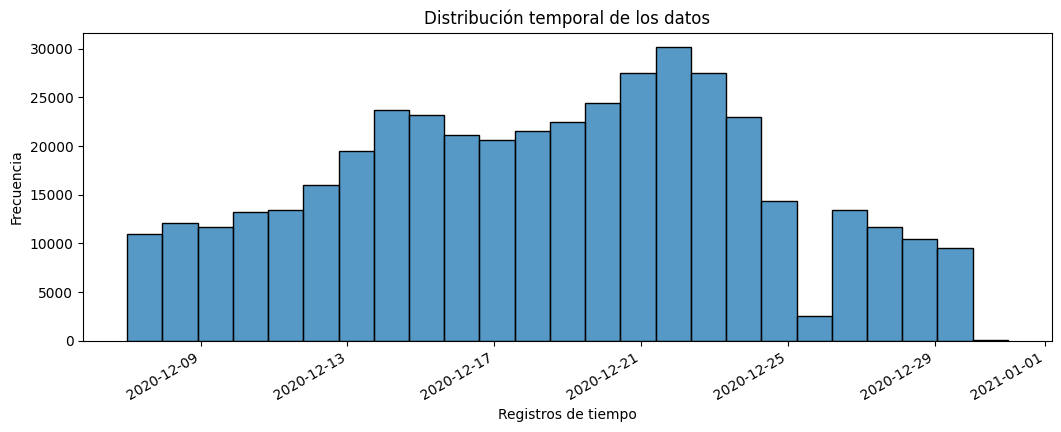

In [88]:
plt.figure(figsize=(12.5, 4))  # Tamaño personalizado

sns.histplot(events['event_dt'], bins=25) # histograma por fecha y hora

# Añadir etiquetas y título
plt.xlabel('Registros de tiempo')
plt.ylabel('Frecuencia')
plt.title('Distribución temporal de los datos')
plt.xticks(rotation=30, ha='right', fontsize=10)

plt.show() # Mostrar gráfico

Se observa una discontinuidad temporal de datos el 25 de diciembre, esto puede deberse a que la gente dejó de usar la aplicación para enfocarse en celebrar navidad y quiza se dio un descanso el día 26. De forma similar ocurrió después del 30 de diciembre. O talvez para esas fechas se agotó stock de ciertos productos.

### Embudo de conversión

La etapa de login se omitirá para el embudo ya que el objetivo es analizar la conversión desde la página de producto, carrito de compras y realización de compra.

In [89]:
# Definir orden real del embudo
funnel_order = ['login', 'product_page', 'product_cart', 'purchase'] 

# Embudo general por actividad/transaccion registrada
funnel_general = events['event_name'].value_counts() # mostrar frecuencia de los eventos.
funnel_general = funnel_general.reindex(funnel_order).tail(3) # ordenar correctamente embudo

# No. usuarios que realizan que pasan por eventos al menos 1 vez
funnel_unique = events.groupby('event_name')['user_id'].nunique() # embudo usuarios únicos 
funnel_unique = funnel_unique.reindex(funnel_order).tail(3) # ordenar correctamente embudo

In [90]:

def i_funnel_dualplot(funnel_1, funnel_2, title, label_1='Funnel 1', label_2='Funnel 2'):
    """
    Crea un gráfico de embudo interactivo con dos conjuntos de datos de embudo.

    Parámetros:
    - funnel_1: DataFrame con el primer conjunto de datos de embudo.
    - funnel_2: DataFrame con el segundo conjunto de datos de embudo.
    - title: Título del gráfico de embudo.
    - label_1: Nombre del primer botón.
    - label_2: Nombre del segundo botón.
    """
    # Crear figura de embudo inicial
    fig = go.Figure(go.Funnel(y=funnel_1.index, x=funnel_1.values))
    fig.update_layout(
        title=title,
        width=650, height=500, plot_bgcolor='rgba(0,0,0,0)'
    )

    # Crear botón interactivo para cambiar el conjunto de datos del embudo
    fig.update_layout(
        updatemenus=[
            {
                'buttons': [
                    {'method': 'restyle',
                     'label': label_1,
                     'args': [{'y': [funnel_1.index], 'x': [funnel_1.values]}]},
                    {'method': 'restyle',
                     'label': label_2,
                     'args': [{'y': [funnel_2.index], 'x': [funnel_2.values]}]}
                ],
                'direction': 'up',
                'showactive': True,
                'x': 1.15,
                'xanchor': 'center',
                'y': 0.13,
                'yanchor': 'top'
            }
        ]
    )

    # Mostrar el gráfico de embudo
    fig.show()

In [91]:
# Trazar embudos de acciones generales y por usuarios únicos
label_1, label_2 = 'Acciones por usuarios únicos', 'Todas las acciones'
title = 'Embudo de Conversión de usuarios'
i_funnel_dualplot(funnel_unique, funnel_general, title, label_1, label_2)

Nótese que hay menos usuarios en la etapa del carrito que en la confirmación de compras, esto puede deberse a que existen ciertos usuarios que no agregaron productos al carrito sino que los compraron inmediatamente desde alguna opción. Lo cual puede ser una buena señal de que la introducción del sistema de compras mejorado dio resultados. 

- El 49.5% de los usuarios (únicos) que navegaron en la página principal añadieron productos al carrito pero el 50.3% realizó concretó las compras; es decir que un 0.8% más realizó también compras directas.

- Respecto a todas las acciones registradas, el 49.7% de las visitas en la página principal añadieron productos al carrito de compras pero el 49.9% realizaron compras; es decir que un 0.2% más fueron también compras directas.

Es posible encontrar a los usuarios que se saltaron el carrito directo a la compra.



In [92]:
events_pivot = pd.pivot_table(data=events, values='event_dt', index='user_id', columns='event_name', aggfunc='count')
events_pivot = events_pivot.fillna(0)
events_pivot = events_pivot[['login', 'product_page', 'product_cart', 'purchase']]

# Usuarios que han realizado compras regulares
print('Compras regulares:', len(events_pivot.query('product_cart>0 and purchase <= product_cart'))) 

# usuarios que compraron sin pasar nunca por el carrito
print('Compras sin carrito:', len(events_pivot.query('product_cart==0 and purchase > 0')))

Compras regulares: 19228
Compras sin carrito: 13169


19228 usuarios hicieron compras normales, pero 13169 compradores nunca pasaron por el carrito de compra.

In [93]:
# Obtener los nuevos usuarios de la region UE
eu_new_users = new_users[new_users['region']=='EU']

# fusionar el dataframe con participants
participants_eu = pd.merge(eu_new_users, participants, on='user_id', how='right')

# Segmentar clientes por grupo A y B
condition_a = "group == 'A' and ab_test == 'recommender_system_test'"
a_participants_eu = participants_eu.query(condition_a)

condition_b = "group == 'B' and ab_test == 'recommender_system_test'"
b_participants_eu = participants_eu.query(condition_b)

# Encontrar usuarios presentes en ambos grupos
common_users = set(a_participants_eu['user_id']) & set(b_participants_eu['user_id'])

# Remover usuarios comunes
a_participants_eu = a_participants_eu[~a_participants_eu['user_id'].isin(common_users)]
b_participants_eu = b_participants_eu[~b_participants_eu['user_id'].isin(common_users)]

# Contar usuarios en grupos a y b
print('a:', len(a_participants_eu))
print('b:', len(b_participants_eu))


a: 2747
b: 928


- 2747 usuarios nuevos de la UE del grupo A (control)
- 928 usuarios nuevos de la UE del grupo B (prueba)

Para el test A/B se elegirá la misma cantidad de usuarios en ambos grupos, por lo que se elgirán 900 participantes únicos en cada equipo. Fueron eliminados los usuarios comunes para que ambos grupos puedan sean independientes y la prueba del sistema recomendador de resultados confiables.

In [94]:
# Consolidar participantes exclusivos 
participants_eu_f = pd.concat([a_participants_eu, b_participants_eu], axis=0)

# Eventos de los participantes de la UE
events_ = events.merge(participants_eu_f, on='user_id', how='right')

# Segmentar eventos por clientes de los grupos A y B
events_a = events_[events_['group']=='A']
events_b = events_[events_['group']=='B']

# Muestrear 900 usuarios de cada grupo.
a_random_users = pd.Series(events_a['user_id'].unique()).sample(900, random_state=42)
b_random_users = pd.Series(events_b['user_id'].unique()).sample(900, random_state=42)

# filtrarlos en la tabla de eventos.
events_f_a = events_a[events_a['user_id'].isin(a_random_users)]
events_f_b = events_b[events_b['user_id'].isin(b_random_users)]

In [95]:
# Embudo de actividad del grupo A
# Embudo general (todas las acciones registradas)
a_funnel_general = events_f_a['event_name'].value_counts() # frecuencia de los eventos.
a_funnel_general = a_funnel_general.reindex(funnel_order).tail(3) # ordenar secuencia 

# Embudo de usuarios únicos por etapa de embudo
a_funnel_unique = events_f_a.groupby('event_name')['user_id'].nunique() 
a_funnel_unique = a_funnel_unique.reindex(funnel_order).tail(3) # ordenar secuencia 

#---------------------------------------------------------------------------------------
# Embudo de actividad del grupo B
# Embudo general por actividad/transaccion registrada en grupo B
b_funnel_general = events_f_b['event_name'].value_counts() # frecuencia de los eventos.
b_funnel_general = b_funnel_general.reindex(funnel_order).tail(3) # ordenar secuencia 

# Embudo de usuarios únicos por etapa de embudo
b_funnel_unique = events_f_b.groupby('event_name')['user_id'].nunique() 
b_funnel_unique = b_funnel_unique.reindex(funnel_order).tail(3) # ordenar secuencia 

In [96]:
# Trazar embudo del grupo A
title = 'Embudo de Conversión de usuarios del Grupo A'
i_funnel_dualplot(a_funnel_unique, a_funnel_general, title, label_1, label_2)

Los 900 usuarios del grupo A sumaron 571 vistas únicas en la página de productos de las cuales el 48.7% añadieron productos al carrito pero un 48.2% realizaron compras; casi todos los usuarios que añadieron productos al carrito compraron.

A nivel general los 900 usuarios del grupo A estuvieon 1710 veces en la página de productos, 842 veces añadieron productos al carrito y 804 veces realizaron compras. Un embudo de actividad general típicamente decreciente.

Podemos definir compras regulares y directas de la siguiente manera:

- Las compras regulares son aquellas en que el usuario pasa por
 __product_page → product_card → purchase__:
 
      Deben haber visitas, agregar productos al carrito y comprar al menos algo del carrito.
                                   
- Las compras irregulares de compra directa son aquellas en que el usuarrio pasa por
 __product_page → purchase__:
 
      Deben haber visitas y deben hacer compras directas sin agregar nada al carrito.

In [131]:
# Crear tabla pivote de actividad general de usuarios del grupo A
events_pivot_f_a = pd.pivot_table(data=events_f_a, values='event_dt', index='user_id', columns='event_name', aggfunc='count')
events_pivot_f_a = events_pivot_f_a.fillna(0)
events_pivot_f_a = events_pivot_f_a[['login', 'product_page', 'product_cart', 'purchase']]

# Usuarios que han realizado compras regulares
reg_purchase = 'product_page > 0 and product_cart > 0 and 0 < purchase <= product_cart' 
print('Compradores regulares:', len(events_pivot_f_a.query(reg_purchase))) 

# usuarios que compraron sin pasar nunca por el carrito
direct_purchase = 'product_page > 0 and product_cart == 0 and 0 < purchase <= product_page'
print('Compradores sin carrito:', len(events_pivot_f_a.query(direct_purchase)))


Compradores regulares: 59
Compradores sin carrito: 131


- 59 usuarios del grupo A pasaron exclusivamente por el proceso regular del embudo
- 131 usuarios del grupo A realizaron compras directas.

Esto indica que más del doble (2.22 veces) de usuarios del grupo A hicieron compras directas sin agregar nada al carrito.

In [98]:
# Trazar embudo del Grupo B
title = 'Embudo de Conversión de usuarios del Grupo B'
i_funnel_dualplot(b_funnel_unique, b_funnel_general, title, label_1, label_2)

Los 900 usuarios del grupo B sumaron 504 vistas únicas en la página de productos de las cuales el 48.4% añadieron productos al carrito y el 48.6% realizaron compras; es decir un 0.2% adicional también realizaron compras directas.

A nivel general los 900 usuarios del grupo B estuvieon 1324 veces en la página de productos, 652 veces añadieron productos al carrito y 637 veces realizaron compras. Un embudo de actividad general típicamente decreciente.

_Nótese que habiendo la misma cantidad de usuarios exclusivos en ambos grupos, el grupo A tuvo más interacciones por volumen, pero proporcionalmente el grupo B tuvo un 0.2% adicional de conversión de compras (48.2% en grupo A y 48.4% en grupo B. Revisar embudos en purchase)._ Conviene revisar más a fondo.

In [133]:
# Crear tabla pivote de actividad general de usuarios del grupo A
events_pivot_f_b = pd.pivot_table(data=events_f_b, values='event_dt', index='user_id', columns='event_name', aggfunc='count')
events_pivot_f_b = events_pivot_f_b.fillna(0)
events_pivot_f_b = events_pivot_f_b[['login', 'product_page', 'product_cart', 'purchase']]

# Usuarios que han realizado compras regulares
reg_purchase = 'product_page > 0 and product_cart > 0 and 0 < purchase <= product_cart' 
print('Compradores regulares:', len(events_pivot_f_b.query(reg_purchase))) 

# usuarios que compraron sin pasar nunca por el carrito
direct_purchase = 'product_page > 0 and product_cart == 0 and 0 < purchase <= product_page'
print('Compradores sin carrito:', len(events_pivot_f_b.query(direct_purchase)))

Compradores regulares: 44
Compradores sin carrito: 107


- 44 usuarios del grupo B pasaron regularmente por cada etapa del embudo
- 107 usuarios del grupo B realizaron compras directas.

Esto indica que más del doble (2.43 veces) de usuarios en el grupo B hicieron compras directas sin agregar nada al carrito
Según los embudos de cada Grupo las proporciones guardan cierta simetría, se puede decir que se distribuyen no tan equitativamente pero razonable.

Sin embargo, el embudo del grupo A tiene una secuencia típicamente decreciente normal, a diferencia del grupo B que en la etapa final se ensancha de forma imperceptible, y esto puede deberse a que el grupo B realizara relativamente un poco de más compras directas que el A. 

    De cualquier modo los perfiles de los embudos son aceptables.

### Distribución de Eventos

Se trazan las distribuciones de las 3 etapas estudiadas de los embudos del grupo A y B entre los días de la prueba.

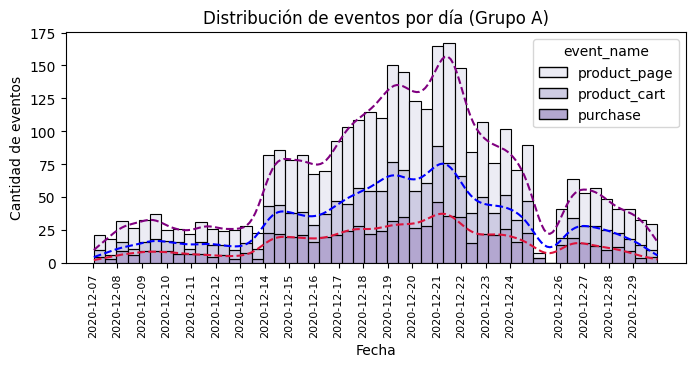

In [134]:
# Utilizar solo los 3 eventos estudiados del embudo
data_a = events_f_a[events_f_a['event_name']!='login']
hue_order = funnel_order[-3:] # orden de histogramas apilados

# Trazar histograma apilado por eventos y personalizado
plt.figure(figsize=(8, 3))
ax = sns.histplot(data=data_a, x='event_dt', hue='event_name', hue_order=hue_order, 
             bins=50, multiple='stack', palette='Purples', kde=True, 
             line_kws={'linestyle': '--'}, kde_kws={'bw_adjust':0.4})

ax.lines[0].set_color('crimson')
ax.lines[1].set_color('blue')
ax.lines[2].set_color('purple')

# Etiquetas
plt.title('Distribución de eventos por día (Grupo A)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de eventos')
plt.xticks(rotation=90)
plt.xticks(data_a['event_dt'].dt.date.unique(), fontsize=8)
plt.show()

In [101]:
# Mostrar fechas de actividad registrada de usuarios
data_a['event_dt'].dt.date.sort_values(ascending=True).value_counts().sort_index().index

Index([2020-12-07, 2020-12-08, 2020-12-09, 2020-12-10, 2020-12-11, 2020-12-12,
       2020-12-13, 2020-12-14, 2020-12-15, 2020-12-16, 2020-12-17, 2020-12-18,
       2020-12-19, 2020-12-20, 2020-12-21, 2020-12-22, 2020-12-23, 2020-12-24,
       2020-12-26, 2020-12-27, 2020-12-28, 2020-12-29],
      dtype='object', name='event_dt')

Los eventos del grupo A tienen una distribución típicamente trimodal:
- **Primer pico:** 14 de diciembre con 90 eventos aprox.
- **Segundo pico:** durante el 21 de diciembre con 170 eventos aprox.
- **Tercer pico:** durante el 26 de diciembre con 65 eventos aprox.

Esos días fueron los de mejor conversión nominal. Sin embargo __no hay actividad registrada el 25,31 de dicimebre ni 1 de enero.__

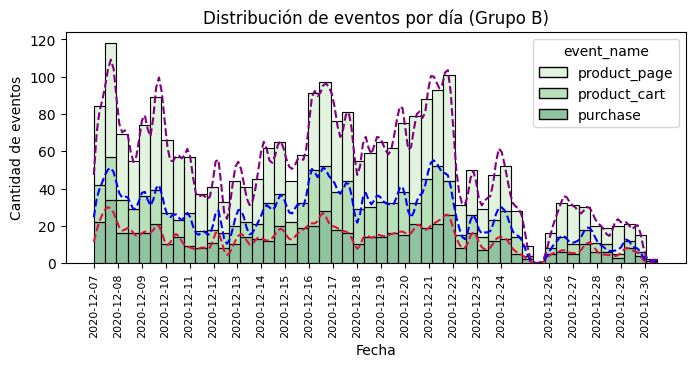

In [135]:
# Utilizar solo los 3 eventos estudiados del embudo
data_b = events_f_b[events_f_b['event_name']!='login']
hue_order = funnel_order[-3:] # orden de histogramas apilados

# Trazar histograma apilado por eventos y personalizado
plt.figure(figsize=(8,3))
ax = sns.histplot(data=data_b, x='event_dt', hue='event_name', hue_order=hue_order, 
             bins=50, multiple='stack', palette='Greens', kde=True, 
             line_kws={'linestyle': '--'}, kde_kws={'bw_adjust':0.1})

ax.lines[0].set_color('crimson')
ax.lines[1].set_color('blue')
ax.lines[2].set_color('purple')
# Etiquetas
plt.title('Distribución de eventos por día (Grupo B)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de eventos')
plt.xticks(rotation=90)
plt.xticks(data_b['event_dt'].dt.date.unique(), fontsize=8)
plt.show()

In [103]:
# Mostrar fechas de actividad registrada de usuarios
data_b['event_dt'].dt.date.sort_values(ascending=True).value_counts().sort_index().index

Index([2020-12-07, 2020-12-08, 2020-12-09, 2020-12-10, 2020-12-11, 2020-12-12,
       2020-12-13, 2020-12-14, 2020-12-15, 2020-12-16, 2020-12-17, 2020-12-18,
       2020-12-19, 2020-12-20, 2020-12-21, 2020-12-22, 2020-12-23, 2020-12-24,
       2020-12-26, 2020-12-27, 2020-12-28, 2020-12-29, 2020-12-30],
      dtype='object', name='event_dt')

Los eventos del grupo B tienen una distribución multimodal:
- **Primer pico:** 7 de diciembre (últimas 12 horas) con 120 eventos aprox.
- **Segundo pico:** 9 de diciembre (últimas 12 horas) con 90 eventos aprox.
- **Tercer pico:** 16 de diciembre con 100 eventos aprox.
- **Cuarto pico:** 21 de diciembre (últimas 12 horas) con 100 eventos aprox. 
- **Quinto pico:** 24 de diciembre (primeras 12 horas) con 50 eventos aprox.
- **Sexto pico:** 26 de diciembre (últimas 12 horas) con 30 eventos aprox.

Esos días fueron los de mejor conversión nominal. Sin embargo __no hay actividad registrada el 25,31 de dicimebre ni 1 de enero.__

El grupo B tuvo 6 días con la mejor conversión nominal (véase eje y de los histogramas). Es posible que el sistema de recomendaciones haya suscitado más compras.

__Peculiaridades:__
- Los usuarios del grupo A se convirtieron volumétricamente más que los usuarios del grupo b.

- El grupo B tuvo más interacciones pico en el tiempo que el grupo A. Aprovechable para ofrecer promociones y no sobrecargar la plataforma la última semana antes de Navidad.

- En ambos grupos No hubo actividad de usuarios los días 25 y 31 de diciembre, ni 1 de enero. Seguramente por ser días de descanso o se agotó el stock de las promociones. Por tanto hay 3 días sin conversión de usuarios.



## Test A/B

In [136]:
# Crear función de datos agregados acumulados
def aggregate_events(events_df, agg_dict, date_col, group_col):
    """
    Agrega eventos por fecha y grupo en un DataFrame.

    Parameters:
    events_df (pd.DataFrame): DataFrame con los datos de eventos.
    agg_dict (dict): Diccionario con las operaciones de agregación.
    date_col (str): Nombre de la columna de fecha.
    group_col (str): Nombre de la columna de grupo.

    Returns:
    pd.DataFrame: DataFrame con los eventos agregados y ordenados por fecha y grupo.
    """
    # Obtener tabla de fechas únicas y grupos
    dates_groups = events_df[[date_col, group_col]].drop_duplicates()

    # Eventos agregados por fecha y grupo            
    events_aggregated = dates_groups.apply(
        lambda x: events_df[
            np.logical_and(
                events_df[date_col] <= x[date_col],  # Eventos donde la fecha es <= a la actual
                events_df[group_col] == x[group_col]  # Eventos donde el grupo coincide con el actual
            )
        ].agg(agg_dict),
        axis=1,
    ).sort_values(by=[date_col, group_col])  # Ordenar por fecha y grupo


    return events_aggregated

In [137]:
# Crear columna de fecha sin timestamp en conjunto de eventos
events_['date'] = events_['event_dt'].dt.date

# Obtener efentos filtrados con las 3 etapas de estudio del embudo
events_f = events_[events_['event_name'] != 'login']
events_f_1 = events_f[events_f['event_name'] == 'product_page']
events_f_2 = events_f[events_f['event_name'] == 'product_cart']
events_f_3 = events_f[events_f['event_name'] == 'purchase']

# Obtener tabla de fechas únicas y grupos
dates_groups = events_f[['date', 'group']].drop_duplicates()

# Diccionario con operaciones de agregación
agg_dict = { 
    "date": "max",  # Colocar fecha máxima por filtro de agregación
    "group": "max",  # colocar grupo máximo por filtro de agregación
    "event_name": "nunique",  # Número de eventos únicos por fecha y grupo
    "user_id": "count",  # Número de usuarios únicos por fecha y grupo
}


In [138]:
# Obtener tabla de agregación acumulativa
cumulative_data = aggregate_events(events_f, agg_dict, 'date', 'group')

# Renombrar columnas adecuadamente
column_names = ['date', 'group', 'events_count', 'user_count']
cumulative_data.columns = column_names 
cumulative_data['conversion'] = cumulative_data['events_count'] / cumulative_data['user_count']
cumulative_data

,date,group,events_count,user_count,conversion
0,2020-12-07,A,3,177,0.016949
18637,2020-12-07,B,3,213,0.014085
494,2020-12-08,A,3,359,0.008357
18651,2020-12-08,B,3,346,0.008671
45,2020-12-09,A,3,566,0.005300
18680,2020-12-09,B,3,535,0.005607
48,2020-12-10,A,3,751,0.003995
18638,2020-12-10,B,3,667,0.004498
86,2020-12-11,A,3,940,0.003191
18783,2020-12-11,B,3,746,0.004021


In [139]:
# Obtener tabla de agregación acumulativa
cumulative_data_1 = aggregate_events(events_f_1, agg_dict, 'date', 'group')

# Renombrar columnas adecuadamente
cumulative_data_1.columns = column_names 
cumulative_data_1

,date,group,events_count,user_count
2,2020-12-07,A,1,96
18850,2020-12-07,B,1,108
494,2020-12-08,A,1,204
18885,2020-12-08,B,1,172
45,2020-12-09,A,1,310
18680,2020-12-09,B,1,278
50,2020-12-10,A,1,404
18782,2020-12-10,B,1,350
86,2020-12-11,A,1,506
18783,2020-12-11,B,1,396


In [108]:

# Obtener tabla de agregación acumulativa
cumulative_data_2 = aggregate_events(events_f_2, agg_dict, 'date', 'group')

# Renombrar columnas adecuadamente
cumulative_data_2.columns = column_names 
cumulative_data_2


,date,group,events_count,user_count
1,2020-12-07,A,1,35
18639,2020-12-07,B,1,46
870,2020-12-08,A,1,72
18855,2020-12-08,B,1,80
177,2020-12-09,A,1,122
18797,2020-12-09,B,1,123
178,2020-12-10,A,1,167
18640,2020-12-10,B,1,157
810,2020-12-11,A,1,212
18820,2020-12-11,B,1,174


In [109]:

cumulative_data_3 = aggregate_events(events_f_3, agg_dict, 'date', 'group')

# Renombrar columnas adecuadamente
cumulative_data_3.columns = column_names
cumulative_data_3


,date,group,events_count,user_count
0,2020-12-07,A,1,46
18637,2020-12-07,B,1,59
3497,2020-12-08,A,1,83
18651,2020-12-08,B,1,94
47,2020-12-09,A,1,134
18893,2020-12-09,B,1,134
48,2020-12-10,A,1,180
18638,2020-12-10,B,1,160
361,2020-12-11,A,1,222
19295,2020-12-11,B,1,176


## Conclusiones